# Visualization with Open Altimetry & Google Earth Engine

## This is adapted from the tutorial in the book

## Computing environment

We'll be using the following Python libraries in this notebook:

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp

    
The import below is a class that the organizers wrote. It helps us read and store data from the OpenAltimetry API.  This line is importing the class `dataCollector` in the file `oa.py` in the `utils` folder.

In [3]:
from utils.oa import dataCollector

## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [4]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Get data URL from the OpenAltimetry API

* Go to [openaltimetry.org](https://openaltimetry.org/)
* Select **BROWSE ICESAT-2 DATA**. 
* Select **ATL 08** on the left
* Select a date
* Click **SELECT A REGION** on the top left, and drew a rectangle
* Right click on the rectangle and select **View Elevation profile**. This opens a pop up, and shows ATL06 and ATL08 elevations. 
* Scroll to the **bottom** and select **Get API URL**. Copy it.

### Another way to get the OA URL


We can now initialize a `dataCollector` object, using the copy-pasted OpenAltimetry API URL, and the beam we would like to look at. 

In [ ]:
is2data = dataCollector(oaurl=oa_api_url,beam=gtx, verbose=True)

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&outputFormat=json&beamName=gt2r&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34956862465471, -70.2449105354736]
Longitude limits: [12.107692195781404, 12.426364789894341]


Alternatively, we could use a date, track number, beam, and lat/lon bounding box as input to the `dataCollector`.

In [7]:
latlims = [-70.34957, -70.24491]
lonlims = [12.10769, 12.42636]
rgt = 312 # track number
gtx = 'gt2r' # The beam
date = '2020-01-16'
is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=gtx, verbose=True)

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34957, -70.24491]
Longitude limits: [12.10769, 12.42636]


Note that this also constructs the API url for us.

### Requesting the data from the OpenAltimetry API
Here we use the `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads ATL03, ATL06 and ATL08 data based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [ ]:
is2data.requestData(verbose=True)

---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


The data are now stored as data frames in our `dataCollector` object. To verify this, we can run the cell below.

In [9]:
vars(is2data)

{'url': 'https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter',
 'date': '2020-01-16',
 'track': 312,
 'beam': 'gt2r',
 'latlims': [-70.34957, -70.24491],
 'lonlims': [12.10769, 12.42636],
 'atl03':              lat        lon           h   conf
 0     -70.244852  12.299888  248.103740  Noise
 1     -70.244859  12.299886  261.201020  Noise
 2     -70.244865  12.299884  243.059620  Noise
 3     -70.244862  12.299884  118.523254  Noise
 4     -70.244859  12.299884    9.918441  Noise
 ...          ...        ...         ...    ...
 46111 -70.349453  12.260788   44.356140   High
 46112 -70.349459  12.260786   45.128857   High
 46113 -70.349472  12.260782   44.818504   High
 46114 -70.349472  12.260782   45.072422   High
 46115 -70.349478  12.260779   44.981472   High
 
 [46116 rows x 4 columns],
 'atl06':            lat        lon          h
 0   -70.245025  12.2

## Plotting the ATL03, ATL06 and ATL08 data

To make plots easier to produce, the `dataCollector` class in `utils/oa.py` has a method to plot the data that we downloaded. 

In [ ]:
fig = is2data.plotData()

Let's wrap this all into a function!

In [6]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

## Exercise 1 
**Find some data from openaltimetry that you would like to read into python, and plot it here.**

Look for small-scale features, where ATL03 photon cloud may give us some information that we would not get from ATL08 or ATL06 (Say a few hundred meters to 20 kilometers along-track. *Hint: OpenAltimetry has a scale bar.*)

If you don't know where to start with OpenAltimetry, you can look at any of these annotations below:
- Like mountains? Look at gt2l [here](http://openaltimetry.org/data/icesat2/?annoId=260&shareKey=6bcd62fe2f581f61c4a1b4b5a4f07de5).
- Like the ocean? Look at gt1r [here](http://openaltimetry.org/data/icesat2/?annoId=505&shareKey=4345379a3318b8c055d026723ca60162).
- Like the previous example but don't wanna go to Antarctica? Look at gt3l [here](http://openaltimetry.org/data/icesat2/?annoId=260&shareKey=6bcd62fe2f581f61c4a1b4b5a4f07de5).
- Curious about more ice shelf suff? Look at gt3r [here](http://openaltimetry.org/data/icesat2/?annoId=207&shareKey=e90e9fb891a716064f5cc8b0e13f750a).
- Can you tell what's going on in gt3r [here](http://openaltimetry.org/data/icesat2/?annoId=504&shareKey=aae14eeca098358c6f9e686ca659a93e)? 

In [20]:
%%capture
url = 'http://openaltimetry.org/data/api/icesat2/atl13?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Coastal Example')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

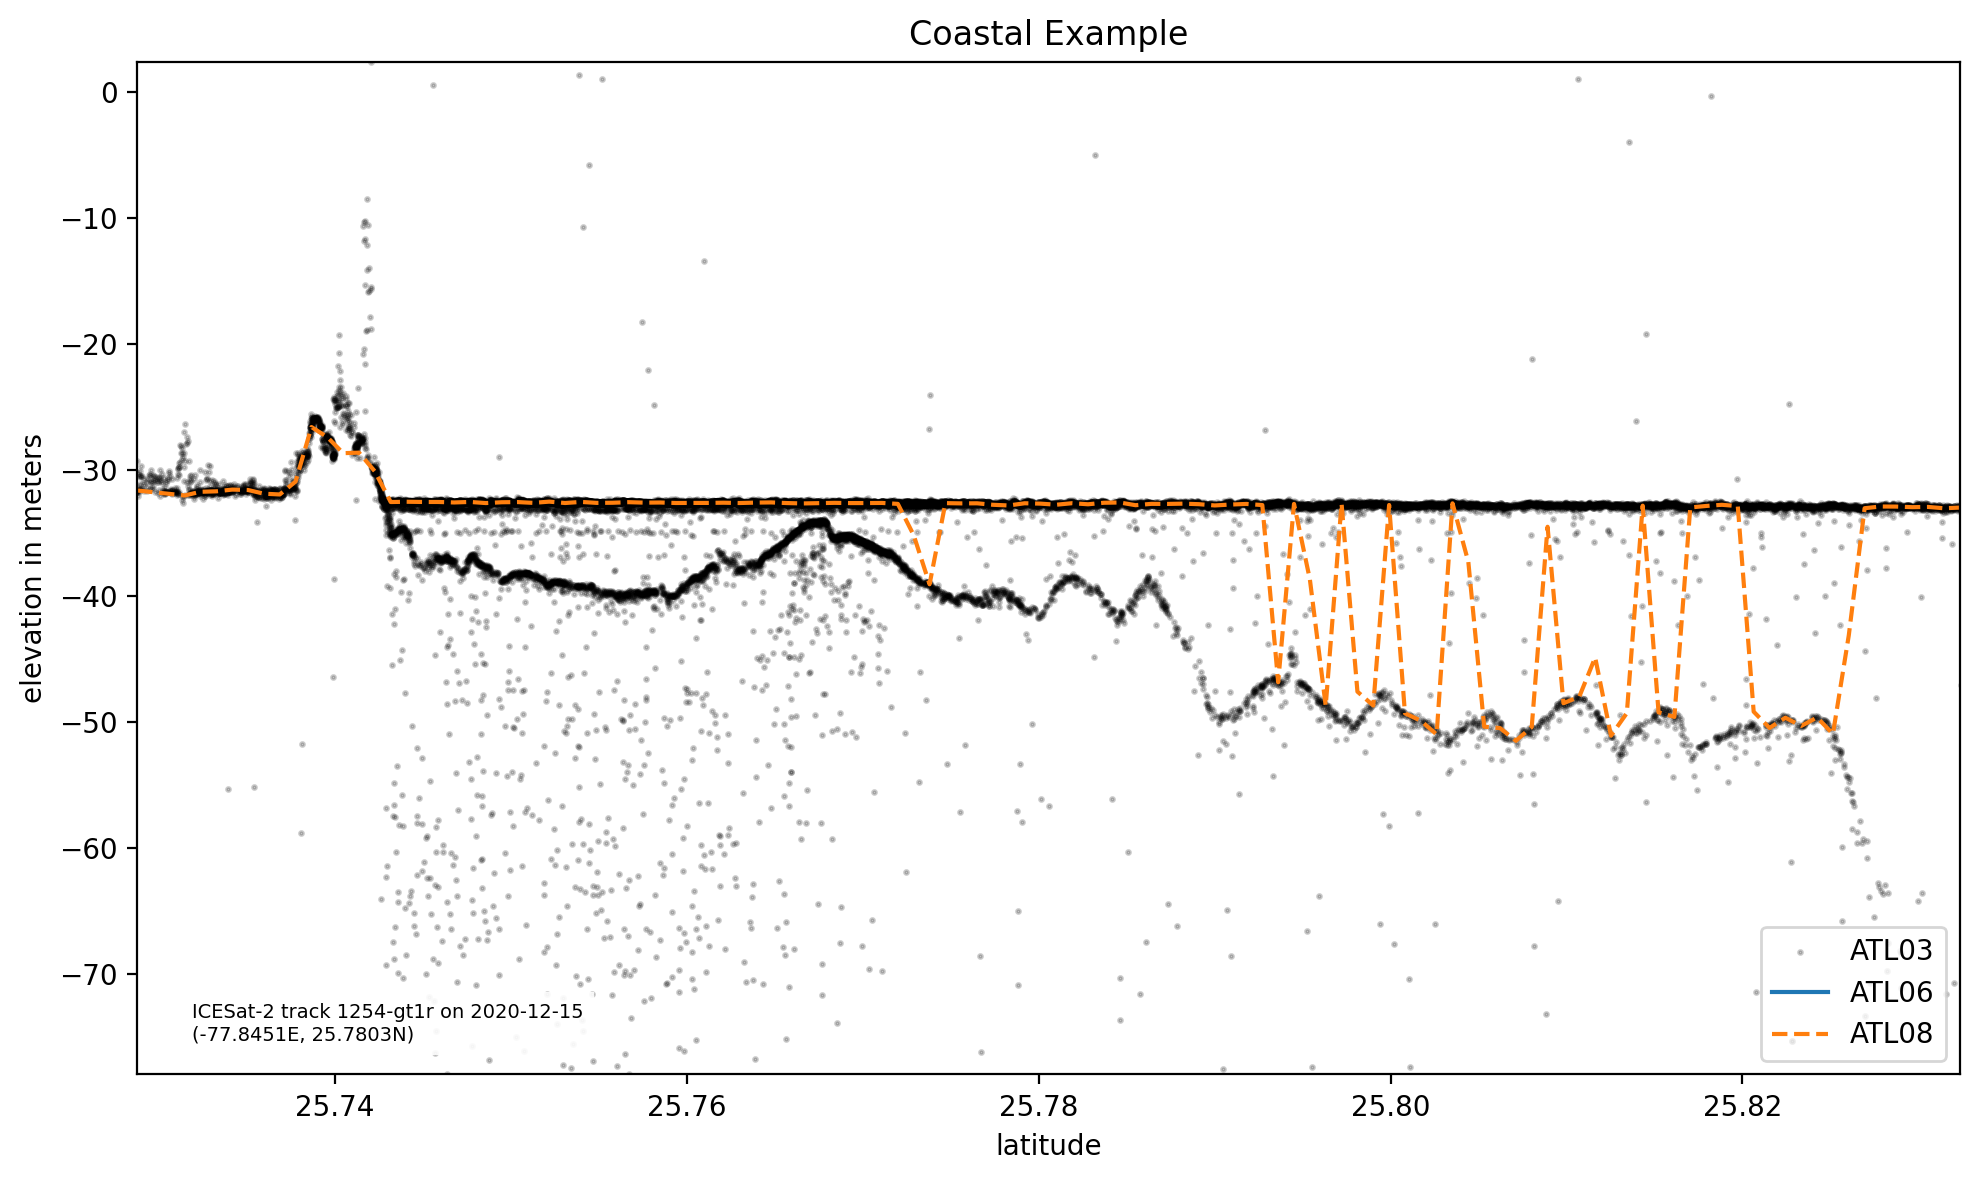

In [21]:
myplot

In [24]:
%%capture
#use capture to prevent the plot
url = 'http://openaltimetry.org/data/api/icesat2/atl12?date=2021-12-15&minx=-154.32381980236076&miny=56.873762230836434&maxx=-154.29895036037468&maxy=56.93202651616244&trackId=1280&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Alaska Coast')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

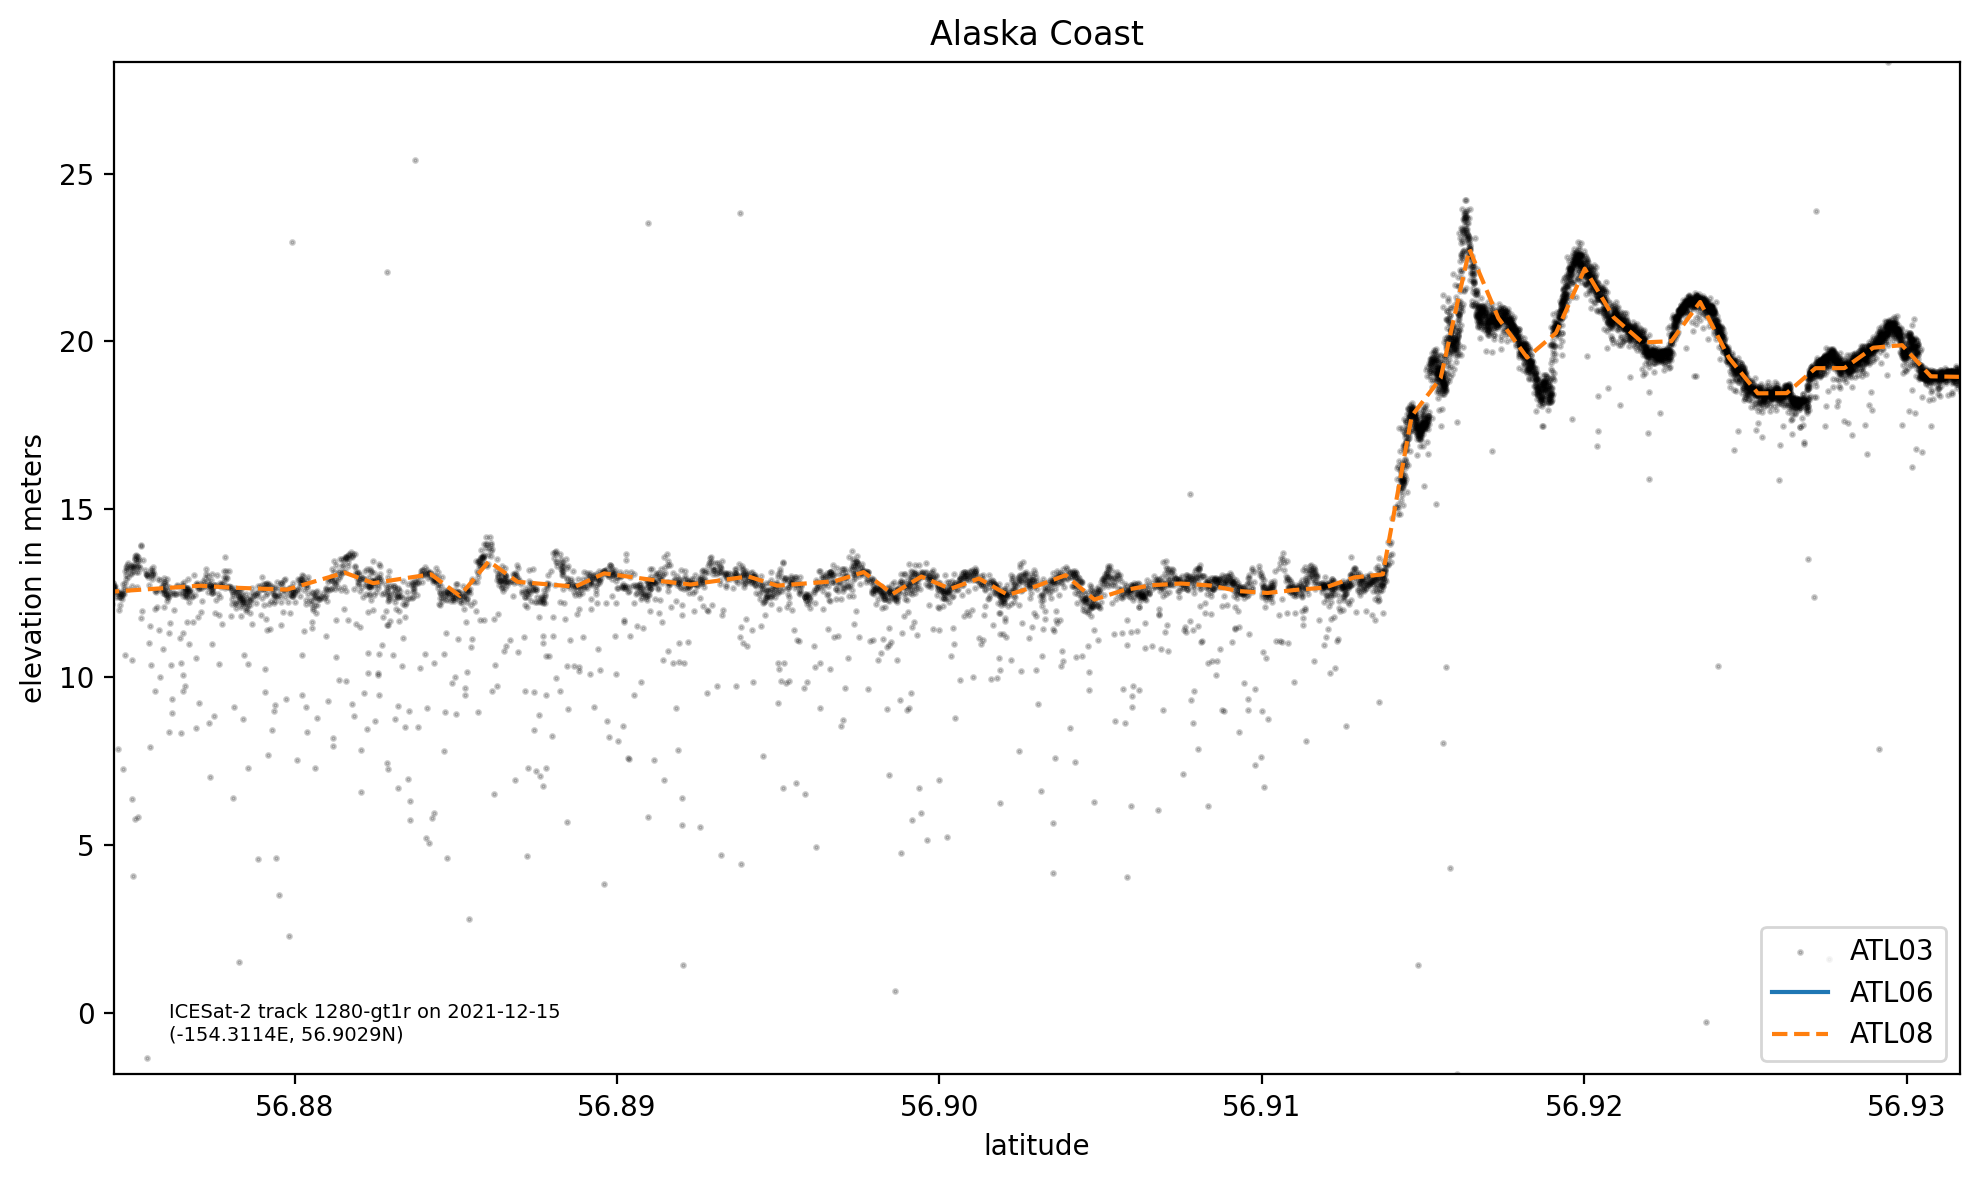

In [25]:
myplot

In [26]:
%%capture
url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Lake Example')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

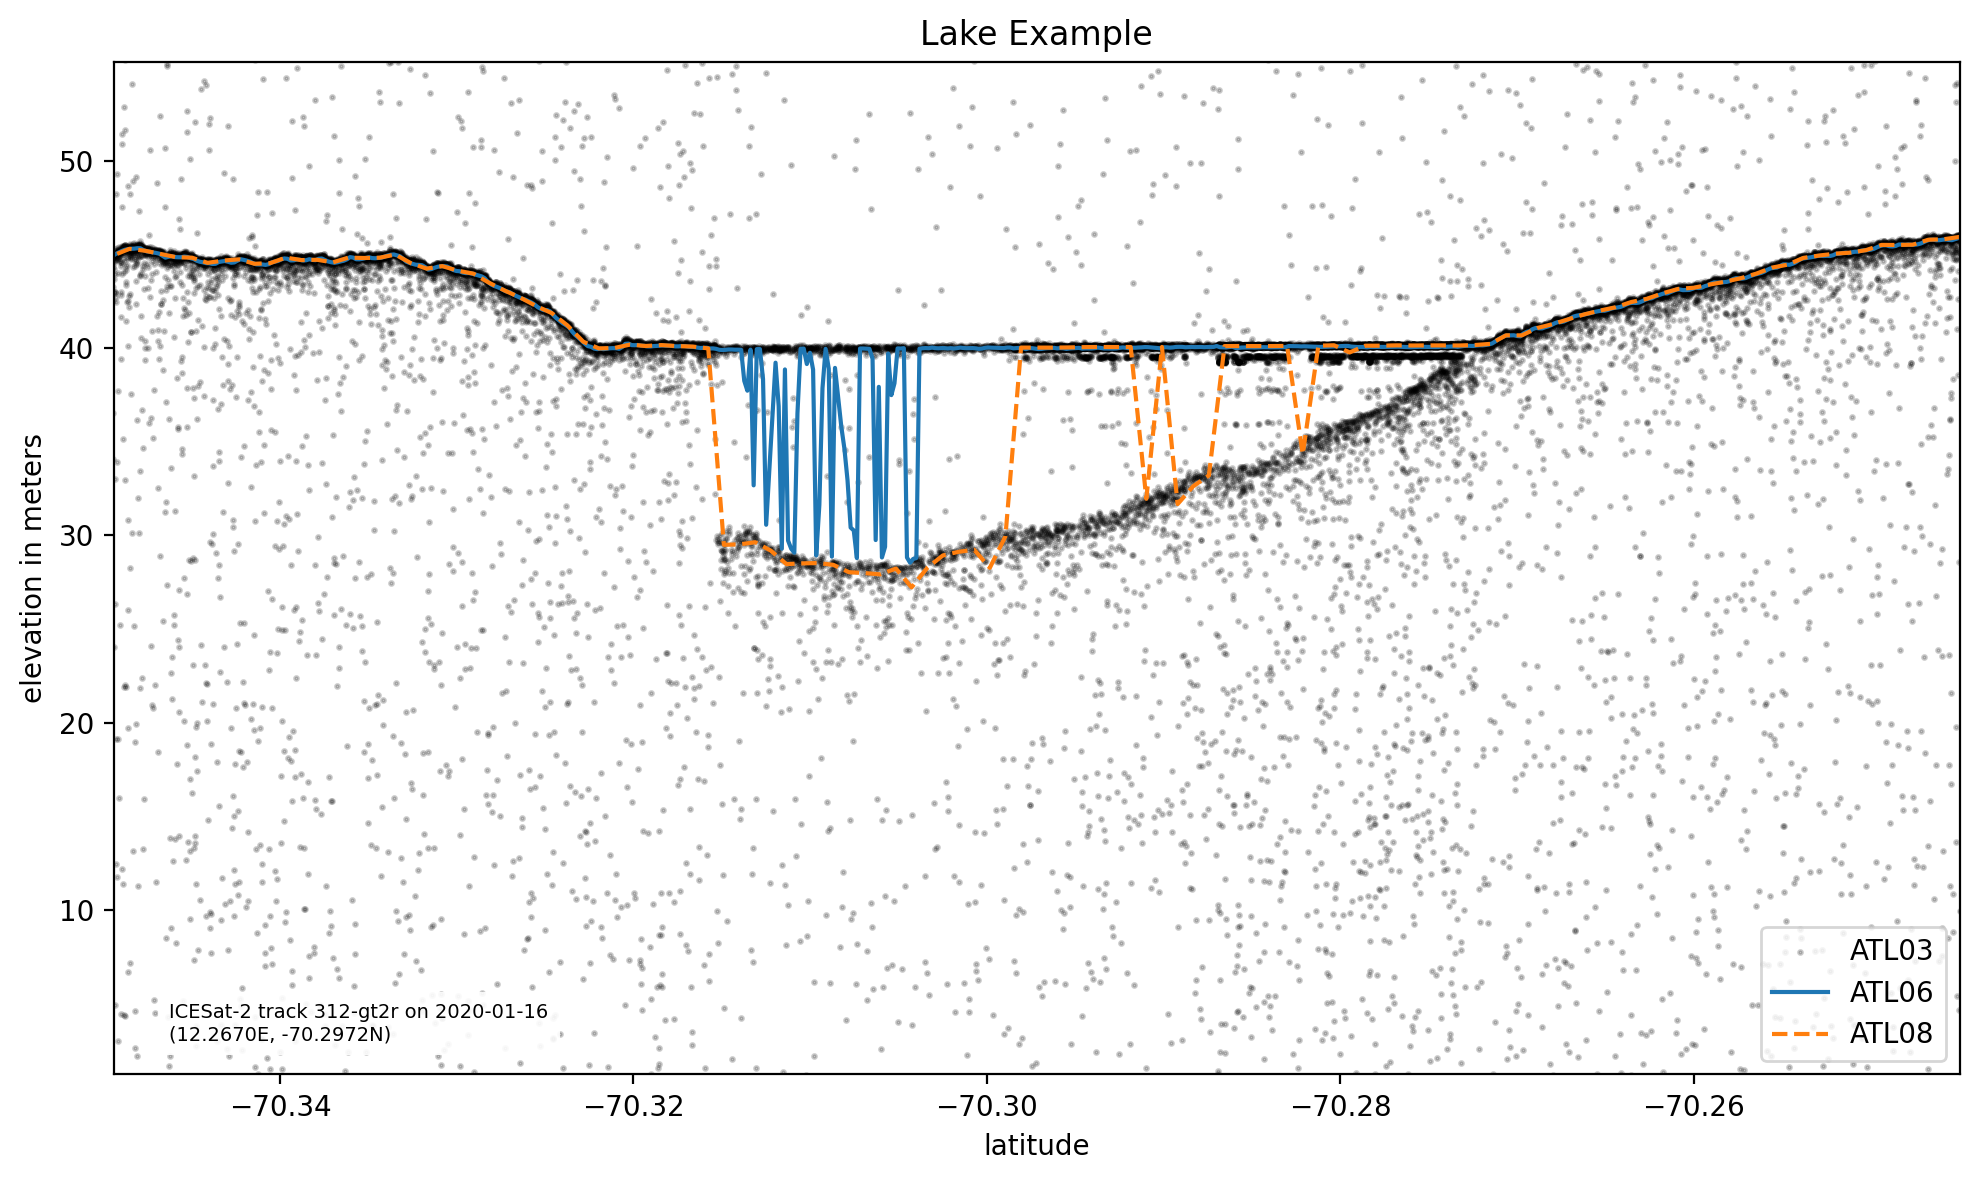

In [27]:
myplot